# feature engineering

to represent the audio in the format as computer understand and to make the model learn the important characteristics of the audio sample, we need to extract perfect values from the audio signals.
There are mainly 2 types of feature engineering:
1. hand made features 
2. using the direct method to extract features

In [40]:
# extract MFCC features from the audio and create dataloaders

# creating dataloaders
source for the code: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html 

feature extraction for audiodata

In [1]:
import torch
import librosa
import numpy as np
from torch.utils.data import Dataset

class Audiodataset(Dataset):
    def __init__(self, audio_files, labels, transform=None, max_length=256):
        self.audio_files = audio_files
        self.labels = labels
        self.transform = transform
        self.max_length = max_length

    def __len__(self):
        return len(self.audio_files)

    def __getitem__(self, idx):
        audio_path = self.audio_files[idx]
        label = self.labels[idx]

        # Load audio file
        y, sr = librosa.load(audio_path, sr=32000)

        # Filter out zero-length audio files
        if len(y) == 0:
            print(f"Warning: {audio_path} has zero length.")
            return self.__getitem__((idx + 1) % len(self))

        # Convert to Mel spectrogram
        mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64, fmin=50, fmax=14000)
        log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

        # Normalize the log Mel spectrogram (standardization)
        mean = np.mean(log_mel_spectrogram, axis=1, keepdims=True)
        std = np.std(log_mel_spectrogram, axis=1, keepdims=True)
        log_mel_spectrogram = (log_mel_spectrogram - mean) / std

        # Pad or trim to max_length
        if log_mel_spectrogram.shape[1] < self.max_length:
            pad_width = self.max_length - log_mel_spectrogram.shape[1]
            log_mel_spectrogram = np.pad(log_mel_spectrogram, ((0, 0), (0, pad_width)), mode='constant')
        else:
            log_mel_spectrogram = log_mel_spectrogram[:, :self.max_length]

        if self.transform:
            log_mel_spectrogram = self.transform(log_mel_spectrogram)

        log_mel_spectrogram = torch.tensor(log_mel_spectrogram, dtype=torch.float32).unsqueeze(0)  # Shape [1, time_steps, mel_bins]
        log_mel_spectrogram = log_mel_spectrogram.permute(0, 2, 1)  # Shape [1, mel_bins, time_steps]
        
        return log_mel_spectrogram, torch.tensor(label, dtype=torch.long)  # Ensure label is a long tensor


preparing the data for training using dataloaders

In [2]:
from torch.utils.data import DataLoader,Dataset
import os
from sklearn.model_selection import train_test_split

#define classes
classes = ['Baby_Cry','Door_Knock','Door_Bell','Fire_Alarm']
image_dir = "C:\\Users\\PC\\Desktop\\lisnen_data\\audio_files\\audio_files"

audio_files = []
labels = []

for label, class_name in enumerate(classes):   #by using enumerate here we're saving index fo an element in label and its value in class_name
    class_dir = os.path.join(image_dir,class_name)
    for file_name in os.listdir(class_dir):
        # check if te file format is valid
        if file_name.endswith('.wav'):  #coz we're working only on wav files
            audio_files.append(os.path.join(class_dir,file_name))
            labels.append(label)


# crating the data splits from audio_files to train, val and test splits
training_audio,dummy_training_audio,training_labels,dummy_training_labels = train_test_split(audio_files,labels,test_size=0.2,shuffle=True,random_state=42)
val_audio,test_audio,val_labels,test_labels = train_test_split(dummy_training_audio,dummy_training_labels,test_size=0.5,shuffle=True,random_state=42)

# save the log mel values in the list format and then create dataloaders
training_data  = Audiodataset(training_audio,training_labels,max_length=256)
validation_data = Audiodataset(val_audio,val_labels,max_length=256)
test_data = Audiodataset(test_audio,test_labels,max_length=256)

# creating the data loaders
train_dataloader = DataLoader(training_data,batch_size=16,shuffle = True)
val_data_loader = DataLoader(validation_data,batch_size=16,shuffle=False)
test_data_loader = DataLoader(test_data,batch_size=16,shuffle=False)
print(f'len of train_dataloader={len(train_dataloader.dataset)}')
print("data loaders are ready for training step")



len of train_dataloader=1508
data loaders are ready for training step


# defining backbone network

In [4]:
# defining a backbone cnn network 
import torch.nn as nn
import sys
sys.path.append("C:\\Users\\PC\\Desktop\\lisnen_research_files\\lisnen_research_files\\audioset_tagging_cnn\\pytorch")
from models import Cnn14
from torchlibrosa.augmentation import SpecAugmentation

class Backbone(nn.Module):
    def __init__(self,sample_rate,window_size,hop_size,mel_bins,fmin,fmax,classes_num):
        super(Backbone, self).__init__()
        # Initialize Cnn14
        self.cnn14 = Cnn14(sample_rate, window_size, hop_size, mel_bins, fmin, fmax, classes_num)
        # Replace the initial layers to accept Mel spectrograms directly
        self.cnn14.spectrogram_extractor = nn.Identity()
        self.cnn14.logmel_extractor = nn.Identity()
        self.cnn14.fc1 = nn.Identity()
        self.cnn14.fc_audioset = nn.Identity()
        
        # Adjust the SpecAugmentation parameters
        self.spec_augmenter = SpecAugmentation(time_drop_width=64, time_stripes_num=2, 
                                               freq_drop_width=8, freq_stripes_num=2)
        # input shape of tensor is (batch_size,no_of_channels,height,width)
        
    def forward(self, x):
        #print(f'sape before augmentation ={x.shape}')
        x = self.spec_augmenter(x)
        #print(f'input shape = {x.shape}')
        c1 = self.cnn14.conv_block1(x, pool_size=(2, 2), pool_type='avg')
        # as per cnn14 in_channels = 1, out_channels = 64
        #print('shape of c1 ',c1.shape)
        c2 = self.cnn14.conv_block2(c1, pool_size=(2, 2), pool_type='avg')
        # as per cnn14 in_channels = 64, out_channels = 128
        #print('shape of c2 ',c2.shape)
        c3 = self.cnn14.conv_block3(c2, pool_size=(2, 2), pool_type='avg')
        #print('shape of c3 ',c3.shape)
        c4 = self.cnn14.conv_block4(c3, pool_size=(2, 2), pool_type='avg')
        #print('shape of c4 ',c4.shape)
        c5 = self.cnn14.conv_block5(c4, pool_size=(2, 2), pool_type='avg')
        #print('shape of c5 ',c5.shape)
        c6 = self.cnn14.conv_block6(c5,pool_size = (1,1), pool_type='avg')
        #print('shape of c6 ',c6.shape)

        return c1,c2, c3, c4, c5,c6




# Defining Feature pyramid network

In [5]:
import torch.nn.functional as F

class FPNWithBackbone(nn.Module):
    def __init__(self, backbone,num_classes):
        super(FPNWithBackbone, self).__init__()
        self.backbone = backbone
        
        # Lateral convolutions to match the number of channels from backbone layers
        self.lateral_conv1 = nn.Conv2d(64, 256, kernel_size=1, stride=1, padding=0)  #64= input channels, 256=output channels
        self.lateral_conv2 = nn.Conv2d(128, 256, kernel_size=1, stride=1, padding=0) #128= input channels,256=output channels
        self.lateral_conv3 = nn.Conv2d(256, 256, kernel_size=1, stride=1, padding=0)  
        self.lateral_conv4 = nn.Conv2d(512, 256, kernel_size=1, stride=1, padding=0)   
        self.lateral_conv5 = nn.Conv2d(1024, 256, kernel_size=1, stride=1, padding=0)   
        self.lateral_conv6 = nn.Conv2d(2048, 256, kernel_size=1, stride=1, padding=0)   

        # Additional layers after FPN
        self.conv1 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.max_pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.max_pool2 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        #final_output_layre
        # Final classification layer
        self.max_pool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.fc1 = nn.Linear(256,2048, bias=True)
        self.fc_audioset = nn.Linear(2048, num_classes, bias=True)

    def forward(self, x):
        # Backbone forward pass
        c1, c2, c3, c4, c5, c6 = self.backbone(x)
        
        # FPN layers
        p6 = self.lateral_conv6(c6)  #lateral conv layer is used to equlaize no of channels
        #print(f'shape of p6 ={p6.shape}')
        p5 = self.lateral_conv5(c5) + p6
        #print(f'shape of p5={p5.shape}')
        p4 = self.lateral_conv4(c4) + F.interpolate(p5, scale_factor=2, mode='nearest')
        #print(f'shape of p4={p4.shape}')
        p3 = self.lateral_conv3(c3) + F.interpolate(p4, scale_factor=2, mode='nearest')
        #print(f'shape of p3={p3.shape}')
        p2 = self.lateral_conv2(c2) + F.interpolate(p3, scale_factor=2, mode='nearest')
        #print(f'shape of p2={p2.shape}')
        p1 = self.lateral_conv1(c1) + F.interpolate(p2, scale_factor=2, mode='nearest')
        #print(f'shape of p1={p1.shape}')
        
        # Additional layers
        out = self.conv1(p1)
        #print('con layer 1 output shape=',out.shape)
        #out = F.relu(out)
        #out = self.max_pool1(out)  # First pooling
        out = self.conv2(out)
        #print('conv layer2 output shape=',out.shape)
        #out = F.relu(out)
        #out = self.max_pool2(out)  # Second pooling
        #out = self.global_avg_pool(out)
        out = self.max_pool(out)
        #print('max pooling output shape',out.shape)
        
        # Flatten and pass through the final fully connected layer
        # out = self.fc(out)  # No activation function here
        # out = F.softmax(out,dim=1)
        out = self.global_avg_pool(out)
        #print('global avg pooling output shape = ',out.shape)
        out = out.view(out.size(0), -1)  # Flatten the tensor
        #print('shape after flattening',out.shape)
        out = F.relu(self.fc1(out))
        #print('shape affter fc layer',out.shape)
        output_class = torch.softmax(self.fc_audioset(out),dim=1)
        #print(output_class)

        
        return output_class


In [6]:
# Define the required parameters
sample_rate = 32000
window_size = 1024
hop_size = 320
mel_bins = 64
fmin = 50
fmax = 14000
classes_num = 4  # Number of classes in your dataset

# Initialize the modified model
backbone = Backbone(sample_rate, window_size, hop_size, mel_bins, fmin, fmax, classes_num)
fpn_model = FPNWithBackbone(backbone,num_classes = classes_num)
fpn_model= fpn_model.cuda()


In [7]:
# loading pre trained weights
import torch
pretrained_path = "C:\\Users\\PC\\Downloads\\cnn14_fine_tuned_model.pth"  # Update this path to your pretrained model file
checkpoint = torch.load(pretrained_path, map_location=torch.device('cuda'))

# Load the pretrained weights, except for the final layer
model_dict = backbone.state_dict()
pretrained_dict = {k: v for k, v in checkpoint.items() if k in model_dict and 'fc_audioset' not in k}
model_dict.update(pretrained_dict)
backbone.load_state_dict(model_dict)
fpn_model.eval()



FPNWithBackbone(
  (backbone): Backbone(
    (cnn14): Cnn14(
      (spectrogram_extractor): Identity()
      (logmel_extractor): Identity()
      (spec_augmenter): SpecAugmentation(
        (time_dropper): DropStripes()
        (freq_dropper): DropStripes()
      )
      (bn0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv_block1): ConvBlock(
        (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv_block2): ConvBlock(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fals

# creating training function to train the model

In [8]:
import torch
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import f1_score, accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt

# Define the training function
def train(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    accumulation_steps = 4

    best_val_accuracy = 0.0
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Use GPU if available

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for i, (inputs, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
            #print(f'shape of inputs={inputs.shape}')
            #print(f'shape of labels={labels.shape}')
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)  # Outputs should be [batch_size, num_classes]

            loss = criterion(outputs, labels)  # Criterion expects outputs and labels in the correct shape
            loss = loss / accumulation_steps  # Normalize loss

            loss.backward()

            if (i + 1) % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100 * correct / total

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.2f}%")

        # Validation
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Validating"):
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)

                loss = criterion(outputs, labels)

                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_epoch_loss = val_running_loss / len(val_loader)
        val_epoch_accuracy = 100 * val_correct / val_total

        val_losses.append(val_epoch_loss)
        val_accuracies.append(val_epoch_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, Val Loss: {val_epoch_loss:.4f}, Val Accuracy: {val_epoch_accuracy:.2f}%")

        # # Save the model if the validation accuracy is the best we've seen so far.
        # if val_epoch_accuracy > best_val_accuracy:
        #     best_val_accuracy = val_epoch_accuracy
        #     torch.save(model.state_dict(), 'best_model.pth')
        #     print(f"Model saved with validation accuracy: {val_epoch_accuracy:.2f}%")

        # Step the scheduler
        scheduler.step()

    return train_losses, train_accuracies, val_losses, val_accuracies



In [9]:
# Visualization function

#train_losses, train_accuracies, val_losses, val_accuracies 
def visualize(train_accuracies,val_accuracies,train_losses,val_losses,num_epochs):
    # Plot training & validation accuracy values
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

In [10]:
# Example usage
# Initialize CNN14 backbone
#backbone = Backbone_Cnn14(sample_rate=32000, window_size=1024, hop_size=320, mel_bins=32, fmin=50, fmax=14000, classes_num=4)

# Initialize FPN
#model = FPNWithBackbone(backbone)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(fpn_model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # Reduce lr by 0.1 every 10 epochs

num_epochs = 25

train_losses, train_accuracies, val_losses, val_accuracies = train(fpn_model, train_dataloader, val_data_loader, criterion, optimizer, scheduler,num_epochs)


Epoch 1/25:   0%|          | 0/95 [00:00<?, ?it/s]C:\Users\PC\AppData\Local\Temp\ipykernel_19108\4013699460.py:35: RuntimeWarning: invalid value encountered in divide
  log_mel_spectrogram = (log_mel_spectrogram - mean) / std
Epoch 1/25:  16%|█▌        | 15/95 [00:05<00:25,  3.17it/s]c:\Users\PC\anaconda3\envs\fpn_pytorch\lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1505
  warnings.warn(
Epoch 1/25: 100%|██████████| 95/95 [00:29<00:00,  3.21it/s]


Epoch 1/25, Train Loss: nan, Train Accuracy: 31.96%


Validating: 100%|██████████| 12/12 [00:02<00:00,  4.26it/s]


Epoch 1/25, Val Loss: nan, Val Accuracy: 31.91%


Epoch 2/25: 100%|██████████| 95/95 [00:19<00:00,  4.81it/s]


Epoch 2/25, Train Loss: nan, Train Accuracy: 31.96%


Validating: 100%|██████████| 12/12 [00:01<00:00,  7.81it/s]


Epoch 2/25, Val Loss: nan, Val Accuracy: 31.91%


Epoch 3/25: 100%|██████████| 95/95 [00:19<00:00,  4.83it/s]


Epoch 3/25, Train Loss: nan, Train Accuracy: 31.96%


Validating: 100%|██████████| 12/12 [00:01<00:00,  8.07it/s]


Epoch 3/25, Val Loss: nan, Val Accuracy: 31.91%


Epoch 4/25: 100%|██████████| 95/95 [00:19<00:00,  4.89it/s]


Epoch 4/25, Train Loss: nan, Train Accuracy: 31.96%


Validating: 100%|██████████| 12/12 [00:01<00:00,  8.43it/s]


Epoch 4/25, Val Loss: nan, Val Accuracy: 31.91%


Epoch 5/25: 100%|██████████| 95/95 [00:19<00:00,  4.77it/s]


Epoch 5/25, Train Loss: nan, Train Accuracy: 31.96%


Validating: 100%|██████████| 12/12 [00:01<00:00,  7.92it/s]


Epoch 5/25, Val Loss: nan, Val Accuracy: 31.91%


Epoch 6/25: 100%|██████████| 95/95 [00:19<00:00,  4.79it/s]


Epoch 6/25, Train Loss: nan, Train Accuracy: 31.96%


Validating: 100%|██████████| 12/12 [00:01<00:00,  7.99it/s]


Epoch 6/25, Val Loss: nan, Val Accuracy: 31.91%


Epoch 7/25: 100%|██████████| 95/95 [00:19<00:00,  4.85it/s]


Epoch 7/25, Train Loss: nan, Train Accuracy: 31.96%


Validating: 100%|██████████| 12/12 [00:01<00:00,  8.19it/s]


Epoch 7/25, Val Loss: nan, Val Accuracy: 31.91%


Epoch 8/25: 100%|██████████| 95/95 [00:19<00:00,  4.86it/s]


Epoch 8/25, Train Loss: nan, Train Accuracy: 31.96%


Validating: 100%|██████████| 12/12 [00:01<00:00,  8.28it/s]


Epoch 8/25, Val Loss: nan, Val Accuracy: 31.91%


Epoch 9/25: 100%|██████████| 95/95 [00:19<00:00,  4.80it/s]


Epoch 9/25, Train Loss: nan, Train Accuracy: 31.96%


Validating: 100%|██████████| 12/12 [00:01<00:00,  7.96it/s]


Epoch 9/25, Val Loss: nan, Val Accuracy: 31.91%


Epoch 10/25: 100%|██████████| 95/95 [00:19<00:00,  4.77it/s]


Epoch 10/25, Train Loss: nan, Train Accuracy: 31.96%


Validating: 100%|██████████| 12/12 [00:01<00:00,  7.95it/s]


Epoch 10/25, Val Loss: nan, Val Accuracy: 31.91%


Epoch 11/25: 100%|██████████| 95/95 [00:20<00:00,  4.74it/s]


Epoch 11/25, Train Loss: nan, Train Accuracy: 31.96%


Validating: 100%|██████████| 12/12 [00:01<00:00,  7.55it/s]


Epoch 11/25, Val Loss: nan, Val Accuracy: 31.91%


Epoch 12/25: 100%|██████████| 95/95 [00:19<00:00,  4.77it/s]


Epoch 12/25, Train Loss: nan, Train Accuracy: 31.96%


Validating: 100%|██████████| 12/12 [00:01<00:00,  8.31it/s]


Epoch 12/25, Val Loss: nan, Val Accuracy: 31.91%


Epoch 13/25: 100%|██████████| 95/95 [00:19<00:00,  4.84it/s]


Epoch 13/25, Train Loss: nan, Train Accuracy: 31.96%


Validating: 100%|██████████| 12/12 [00:01<00:00,  8.22it/s]


Epoch 13/25, Val Loss: nan, Val Accuracy: 31.91%


Epoch 14/25: 100%|██████████| 95/95 [00:19<00:00,  4.89it/s]


Epoch 14/25, Train Loss: nan, Train Accuracy: 31.96%


Validating: 100%|██████████| 12/12 [00:01<00:00,  8.26it/s]


Epoch 14/25, Val Loss: nan, Val Accuracy: 31.91%


Epoch 15/25: 100%|██████████| 95/95 [00:19<00:00,  4.86it/s]


Epoch 15/25, Train Loss: nan, Train Accuracy: 31.96%


Validating: 100%|██████████| 12/12 [00:01<00:00,  8.17it/s]


Epoch 15/25, Val Loss: nan, Val Accuracy: 31.91%


Epoch 16/25:  37%|███▋      | 35/95 [00:07<00:12,  4.65it/s]


KeyboardInterrupt: 

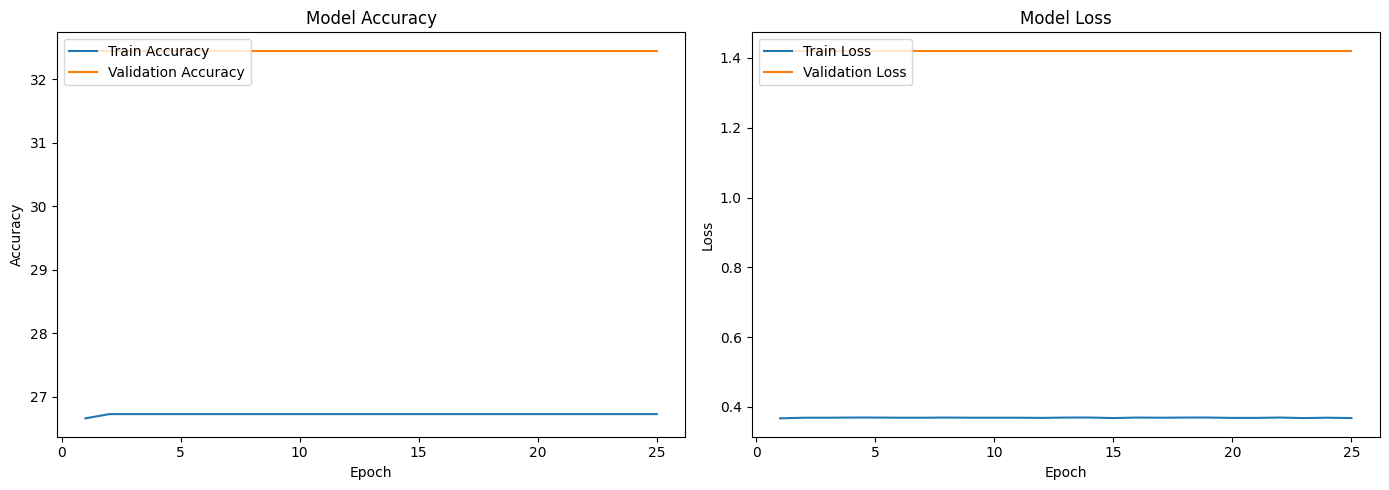

In [ ]:
visualize(train_accuracies,val_accuracies,train_losses,val_losses,num_epochs)